In [1]:
#Loading Libraries
import numpy as np # linear algebra
import  pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sn
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential


2024-06-15 10:50:54.554282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 10:50:54.554540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 10:50:54.706169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
train_df=pd.read_csv("/kaggle/input/google-stock-prices-training-and-test-data/Google_Stock_Price_Train.csv")
test_df=pd.read_csv("/kaggle/input/google-stock-prices-training-and-test-data/Google_Stock_Price_Test.csv")

In [8]:
#Claening and Formattig columns to the right format
train_df['Volume']=train_df['Volume'].str.replace(",","",regex=True)
train_df['Close']=train_df['Close'].str.replace(",","",regex=True)
train_df['Close']=pd.to_numeric(train_df['Close'])
train_df['Volume']=pd.to_numeric(train_df['Volume'],errors="coerce")

In [9]:
#Setting time variable as index for easy plotting and time realted calculations
train_df.set_index("Date",drop=True,inplace=True)  
train_df.index=pd.to_datetime(train_df.index)
test_df['Date']=pd.to_datetime(test_df['Date'])
test_df.set_index("Date",drop=True,inplace=True)

In [11]:
#Taking the Time Dependent Variable / Target Variable for time seris modelling
train_df=train_df[["Open"]]  
test_df=test_df[['Open']]

In [12]:
#Nomrmalizing the data values
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train_df)
scaled_test =scaler.transform(test_df)

In [14]:
#Generator object creating for inputing the data as a generator of batch size 32 
#For predictoing the current time stamp we use previous 12 time steps data values
train_generator=TimeseriesGenerator(scaled_train,scaled_train,length=12,batch_size=32)

In [16]:
#We will predict the data of all the dates present in text so we are using the last 12 vlaues of train data
scaled_test2=np.append(scaled_train[-12:],scaled_test)

In [17]:
test_generator=TimeseriesGenerator(scaled_test2,scaled_test2,length=12,batch_size=32)

In [19]:
#Building model
model=Sequential()
model.add(LSTM(units=200,kernel_initializer="he_normal",input_shape=(12,1)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(Dense(1))

In [20]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer='adam',loss='mse',metrics=[MeanSquaredError()])

In [21]:
model.fit(train_generator,epochs=100)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1547 - mean_squared_error: 0.1549
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010 - mean_squared_error: 0.0010 
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8085e-04 - mean_squared_error: 6.8093e-04
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.4701e-04 - mean_squared_error: 7.4710e-04
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.0659e-04 - mean_squared_error: 7.0680e-04
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.8425e-04 - mean_squared_error: 7.8372e-04
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 

In [22]:
test_preds=model.predict(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


In [23]:
result_df=pd.DataFrame(list(zip(scaler.inverse_transform(test_preds).reshape(-1) ,
                                scaler.inverse_transform(scaled_test).reshape(-1))),
                       columns=["Predicted","Actual"])

In [24]:
result_df.index=test_df.index

In [39]:
result_df.loc["2017-01-03":]

,Predicted,Actual
Date,,
2017-01-03,779.291809,778.81
2017-01-04,776.285461,788.36
2017-01-05,782.958374,786.08
2017-01-06,782.485657,795.26
2017-01-09,788.868408,806.40
2017-01-10,798.324585,807.86
2017-01-11,800.810120,805.00
2017-01-12,798.974976,807.14
2017-01-13,800.388123,807.48


<Axes: title={'center': 'Predicted VS Actual  Values for Jan 2017'}, xlabel='Date'>

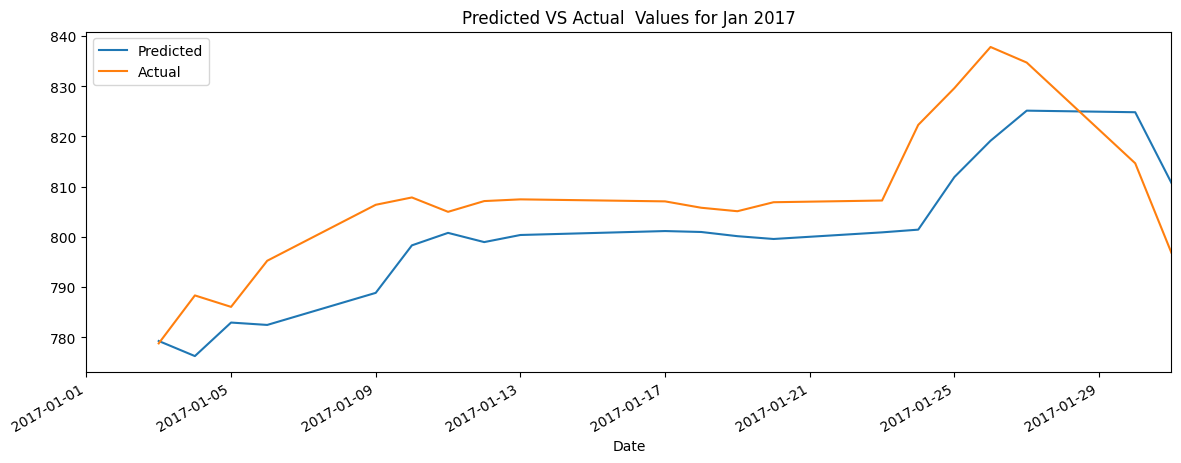

In [41]:
result_df.loc["2017-01-03":].plot(figsize=(14,5),title="Predicted VS Actual  Values for Jan 2017",
                                  xlim=["01-01-2017","31-01-2017"])